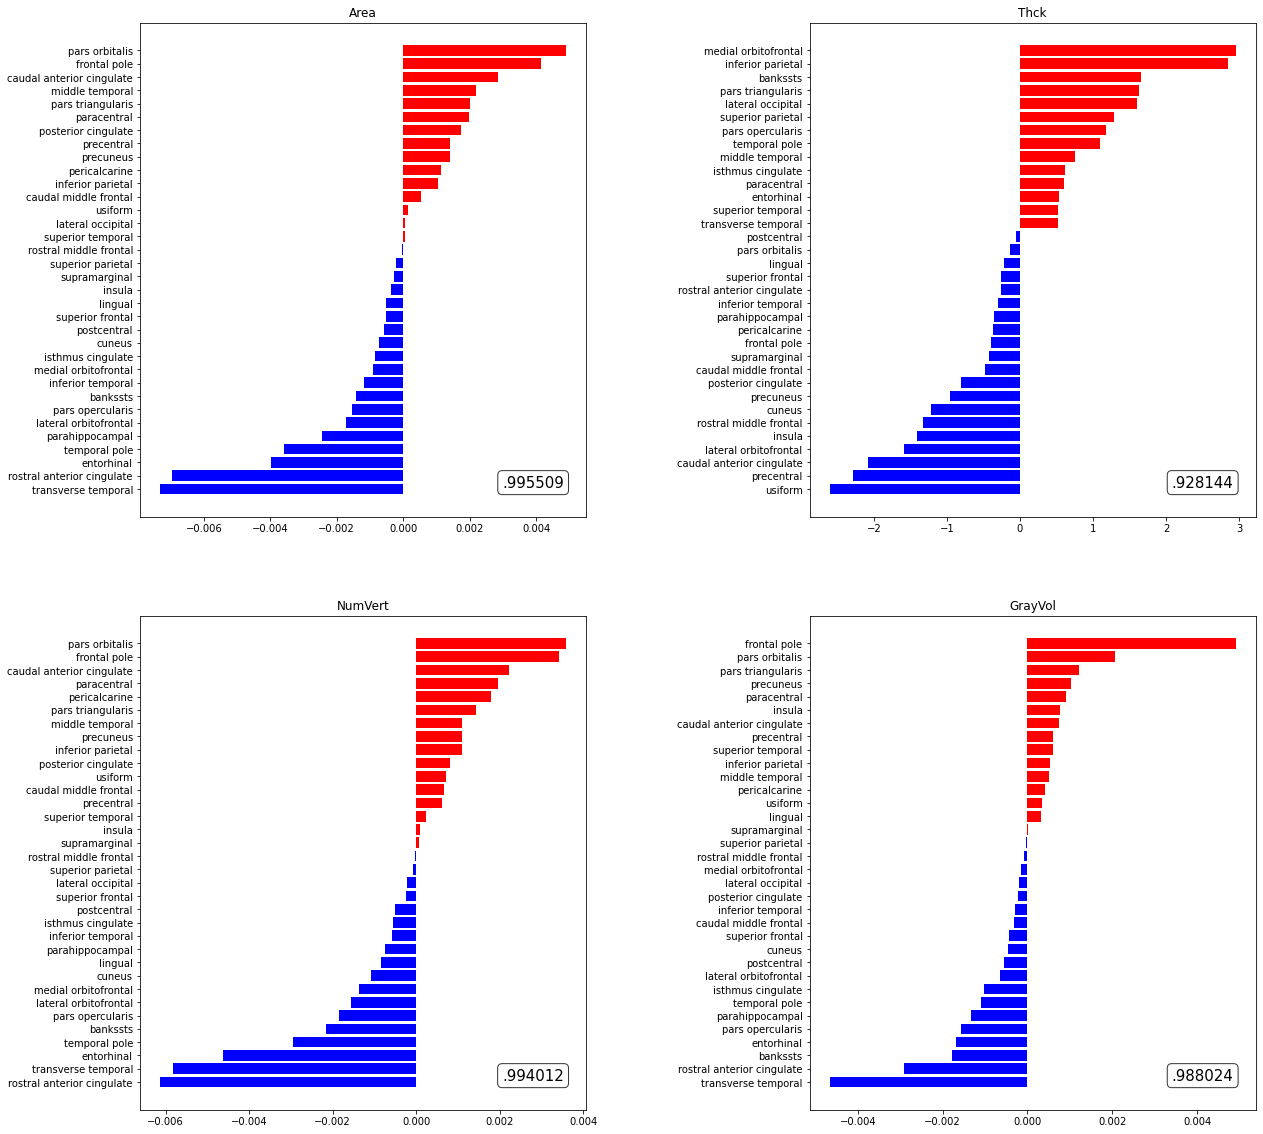

In [59]:
###Since the Python library was lost after my VS Code update, the following code is compiled in Google Colab
### #=========================Import the necessary libraries==========================================
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

### #=======================Import the data==========================================

data = pd.read_csv(r'/unrestricted_hcp_freesurfer.csv',index_col=['Subject'])
data_new = data.copy() #Backup data to prevent loss and facilitate modification


### #=====================Extract the feature of the Left and Right hemispheres====================================

columns = data_new.columns.tolist()
#Extract the left
left_columns = []
for i in columns:
    if "FS_L" in i:
        left_columns.append(i)
Left = data_new[left_columns]
#Extract the right
right_columns = []
for i in columns:
    if "FS_R" in i:
        right_columns.append(i)
Right = data_new[right_columns]

#The left and right brain (i.e. "L" and "R") in the labels of the two brain hemis are removed to facilitate subsequent data integration
first_data_columns1 = []
for i in right_columns:
    first_data_columns1.append(i.replace('R','',1))

first_data_columns2 = []
for i in left_columns:
    first_data_columns2.append(i.replace('L','',1))

#Label extraction is further carried out to ensure that the characteristics of both sides of the brain are the same (that is, there is no characteristic of the left brain or the right brain), so as to facilitate the subsequent integration of the two data into a structure
second_data_columns = [value for value in first_data_columns1 if value in first_data_columns2]

#Update left and right brain tags and merge left and right brain data into a structure
#The left and right brain labels were added to facilitate the extraction of the features of both the left and right brains obtained from the extracted parts of the above labels from the original total data set
left_columns_new = []
for i in second_data_columns:
    left_columns_new.append(i.replace('FS_','FS_L',1))
Left_new = data_new[left_columns_new]

right_columns_new = []
for i in second_data_columns:
    right_columns_new.append(i.replace('FS_','FS_R',1))
Right_new = data_new[right_columns_new]


### #===================Integrate the left and the right========================================

#Add a list of labels ("BrainType") to distinguish between the left and right, with 1 representing the right and 0 representing the left
Right_add = pd.concat([Right_new,pd.DataFrame([1]*1113,index=Right_new.index.values.tolist(),columns=['BrainType'])],axis=1)
Left_add = pd.concat([Left_new,pd.DataFrame([0]*1113,index=Left_new.index.values.tolist(),columns=['BrainType'])],axis=1)

second_data_columns.append('BrainType')

#Integration
s1 = Left_add
s1.columns = second_data_columns
s2 = Right_add
s2.columns = second_data_columns
final_data = pd.concat([s1,s2])
#After integration, the labels are rearranged for easy shuffling
final_replace = final_data.reset_index(drop=True)
#Shuffling data order and rearranging labels ensures randomness
final_ran = final_replace.take(np.random.permutation(len(final_replace.index.values.tolist())))
final_ran_final = final_ran.reset_index(drop=True)


### #==================Training set and test set division, important function defination=======================

#Extracting features and results
data_brain = final_ran_final.copy()
y = data_brain.BrainType
mid = data_brain.columns.values.tolist()
mid.pop(-1)
X = data_brain[mid]

final_columns = final_ran_final.columns.tolist()

#Define the classification function, used to get the classification accuracy and classifier
def score(name,label,aim_dic={}):
    aim_list = []
    for i in range(len(final_columns)):
        if label in final_columns[i]:
            aim_list.append(final_columns[i])
    Aim_Frame = final_ran_final[aim_list]
    X_train,X_test,Y_train,Y_test = train_test_split(Aim_Frame,y,test_size = 0.3,random_state = 0)
    clf = SVC(kernel = 'linear').fit(X_train,Y_train)
    aim_dic[name] = clf.score(X_test,Y_test)
    return aim_dic,clf

#Define a plotting function to draw a bar graph of the contribution of each feature in the trained classifier
def f_importance(imp,names,ax):
    imp = imp.tolist()[0]
    imp,names = zip(*sorted(zip(imp,names)))
    color_boundary = np.array(imp) > 0
    color_list = []
    for i in color_boundary:
        if i:
            color_list.append('r')
        else:
            color_list.append('b')
    ax.barh(range(len(names)), imp, align='center',color=color_list)
    ax.set_yticks(range(len(names)))
    ax.set_yticklabels(names)


### #================Specific category feature training and result visualization===========================

list1 = ["Area","Thck","NumVert","GrayVol"]
list2 = ["_Area","_Thck","_NumVert","_GrayVol"]

#Import the complete brain region name (region corresponding) to facilitate the visualization of labels
regions = pd.read_excel(r"/regions.xlsx")
region_list = regions["region"].tolist()

fig,axes = plt.subplots(2,2,figsize=(20,20))
plt.subplots_adjust(wspace=0.5)
result={}
for i in range(len(list1)):
  if i-2<0:
    ax = axes[0,i]
  elif i-2<2
  #Classification accuracy is displayed in the lower right corner:
    ax = axes[1,i-2]
  result,clf = score(list1[i],list2[i],result)
  f_importance(clf.coef_,region_list,ax)
  ax.set_title(list1[i])
  ax.text(0.95,0.06,('%f'%result[list1[i]]).lstrip('0'),size=15,bbox=dict(boxstyle='round',alpha=0.8,facecolor='white'),transform=ax.transAxes,horizontalalignment='right')